# Интеллектуальный анализ данных – весна 2025
# Домашнее задание 6: классификация текстов

Правила:



*   Домашнее задание оценивается в 10 баллов.
*   Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.
*  Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.
*  Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.
*  Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.
* Если в задании есть вопрос на рассуждение, то за отсутствие ответа на него балл за задание будет снижен вполовину.

В этом домашнем задании вам предстоит построить классификатор текстов.

Будем предсказывать эмоциональную окраску твиттов о коронавирусе.



In [1]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [39]:
url = 'https://raw.githubusercontent.com/hse-ds/iad-intro-ds/refs/heads/master/2025/homeworks/hw06_texts/tweets_coronavirus.csv'
df = pd.read_csv(url, encoding='latin-1')
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
28572,38865,83817,Dallas,08-04-2020,"IÃÂm still shopping for #facemasks online, t...",Positive
3809,8421,53373,"Outside, standing on a bucket",18-03-2020,Supermarkets to manage supplies: SainsburyÃÂ...,Negative
11617,17889,62841,NaN,21-03-2020,"A snapchat filter, a book and a trip to the su...",Extremely Negative
14483,21391,66343,NaN,23-03-2020,Due to the COVID 19 crisis we are facing many ...,Extremely Positive


Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)



## Задание 1 Подготовка (0.5 балла)

Целевая переменная находится в колонке `Sentiment`.  Преобразуйте ее таким образом, чтобы она стала бинарной: 1 - если у твитта положительная или очень положительная эмоциональная окраска и 0 - если отрицательная или очень отрицательная.

In [40]:
df["Sentiment"].unique()
df["Sentiment"] = df["Sentiment"].apply(lambda x: 1 if "Positive" in x or "Extremely Positive" in x else 0)
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
25568,35109,80061,NaN,06-04-2020,ÃÂ Is it better to order groceries online or...,1
2461,6784,51736,Internet,18-03-2020,"""As the #coronavirus spreads across America ma...",0
13115,19712,64664,"San Francisco, CA | Washington DC",22-03-2020,"In the past few days, some Americans are strug...",1
8938,14656,59608,"Phoenix, Arizona",20-03-2020,Grocery shopping online for pick-up? Be sure t...,1


Сбалансированы ли классы?

In [42]:
print(df["Sentiment"].value_counts(normalize=True))

Sentiment
1    0.539589
0    0.460411
Name: proportion, dtype: float64


**Ответ:** Классы сбалансированы, их доли близки к 50%

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их строкой 'Unknown'.

In [43]:
print(df.isnull().sum())

UserName            0
ScreenName          0
Location         7049
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64


In [44]:
df.fillna("Unknown", inplace=True)
print(df.isnull().sum())

UserName         0
ScreenName       0
Location         0
TweetAt          0
OriginalTweet    0
Sentiment        0
dtype: int64


Разделите данные на обучающие и тестовые в соотношении 7 : 3 и укажите `random_state=0`

In [45]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3, random_state=0)

## Задание 2 Токенизация (3 балла)

Постройте словарь на основе обучающей выборки и посчитайте количество встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведения токенов в нижний регистр.

In [46]:
from collections import Counter

tokens = []
for tweet in train["OriginalTweet"]:
  tokens.extend(tweet.lower().split())
tokens_count = Counter(tokens)

Какой размер словаря получился?

In [47]:
print(len(tokens_count))

79755


Выведите 10 самых популярных токенов с количеством встреч каждого из них. Объясните, почему именно эти токены в топе.

In [48]:
print(tokens_count.most_common(10))

[('the', 26815), ('to', 23373), ('and', 14684), ('of', 13012), ('a', 11737), ('in', 11198), ('for', 8566), ('#coronavirus', 8223), ('is', 7383), ('are', 7050)]


**Ответ:** 9 из 10 слов являются функциональными и связывают друг с другом содержательные слова твитов, в языке они встречаются чаще всего, #coronavirus ожидаемо будет одним из самых частых токенов в пуле твитов про коронавирус.

Удалите стоп-слова из словаря и выведите новый топ-10 токенов (и количество встреч) по популярности.  Что можно сказать  о нем?

In [49]:
import nltk
from nltk.corpus import stopwords

nltk.download("stopwords")
new_tokens = {}
for token, count in tokens_count.items():
    if token not in stopwords.words("english"):
        new_tokens[token] = count
new_tokens_count = Counter(new_tokens)
print(new_tokens_count.most_common(10))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


[('#coronavirus', 8223), ('prices', 3891), ('food', 3820), ('grocery', 3469), ('supermarket', 3288), ('people', 3175), ('covid-19', 3173), ('store', 3155), ('#covid19', 2471), ('&amp;', 2314)]


**Ответ:**  судя по полученному топ-10 токенов, во время пандемии люди были наиболее озабочены ростом цен на продукты в магазинах.

Также выведите 20 самых непопулярных слов (если самых непопулярных слов больше, выведите любые 20 из них) Почему эти токены непопулярны, требуется ли как-то дополнительно работать с ними?

In [50]:
print(new_tokens_count.most_common()[:-21:-1])

[('https://t.co/7j2y3rsld9', 1), ('@680news', 1), ('@torontopearson', 1), ('nothing...', 1), ('flew', 1), ('wage!', 1), ('renewing', 1), ('playersã\x82â\x92', 1), ('subsidise', 1), ('non-playing', 1), ('premiership', 1), ('https://t.co/iaek4fwsgz', 1), ('@srinivasiyc', 1), ('https://t.co/zjcl195vqs', 1), ('#southkerry', 1), ('#skelligcoast2kms', 1), ('@skelligsix18', 1), ('closer!)', 1), ('coast!', 1), ('skellig', 1)]


**Ответ:** эти токены - редкие ссылки, тэги или наименования, которые естественным образом редко встречаются в твитах. Как мне кажется, они требуют дополнительной работы с ними, они упростят работу модели, поскольку не несут существенной информации.



Теперь воспользуемся токенайзером получше - TweetTokenizer из библиотеки nltk. Примените его и посмотрите на топ-10 популярных слов. Чем он отличается от топа, который получался раньше? Почему?

In [51]:
from nltk.tokenize import TweetTokenizer

tokenizer = TweetTokenizer()
tweet_tokens = []
for tweet in train['OriginalTweet']:
  tokens = tokenizer.tokenize(tweet)
  tweet_tokens.extend([token.lower() for token in tokens])
tokens_count = Counter(tweet_tokens)
print(tokens_count.most_common(10))

[('the', 26993), ('.', 24118), ('to', 23478), (',', 17571), ('and', 14825), ('of', 13044), ('a', 11891), ('in', 11348), ('?', 9524), ('#coronavirus', 8808)]


**Ответ:** Теперь в топе появились знаки препинания, раннее их не было, поскольку мы делили токены по пробелам, поэтому знаки препинания не выделялись, как отдельные токены, они оставались на конце слов.

Удалите из словаря стоп-слова и пунктуацию, посмотрите на новый топ-10 слов с количеством встреч, есть ли теперь в нем что-то не похожее на слова?

In [52]:
from string import punctuation

new_tokens = {}
for token, count in tokens_count.items():
  if token not in stopwords.words("english") and token not in punctuation:
    new_tokens[token] = count
new_tokens_count = Counter(new_tokens)
print(new_tokens_count.most_common(10))

[('#coronavirus', 8808), ('â', 7415), ('\x82', 7311), ('19', 7167), ('covid', 6253), ('prices', 4601), ('\x92', 4372), ('food', 4367), ('store', 3877), ('supermarket', 3805)]


**Ответ:** Да, в топе есть токены, соответствующие символам кавычек, которые корректно не отображаются, и буква не из латинского алфавита.

Скорее всего в некоторых топах были неотображаемые символы или отдельные буквы не латинского алфавита. Уберем их: удалите из словаря токены из одного символа, позиция которого в таблице Unicode 128 и более (`ord(x) >= 128`)

Выведите топ-10 самых популярных и топ-20 непопулярных слов. Чем полученные топы отличаются от итоговых топов, полученных при использовании токенизации по пробелам? Что теперь лучше, а что хуже?

In [56]:
filtered_tokens = {}
for token, count in new_tokens_count.items():
  if len(token) > 1 or ord(token[0]) < 128:
    filtered_tokens[token] = count
new_tokens_count = Counter(filtered_tokens)
print("Топ-10 популярных: ", new_tokens_count.most_common(10))
print("Топ-20 непопулярных: ", new_tokens_count.most_common()[: -21: -1])

Топ-10 популярных:  [('#coronavirus', 8808), ('19', 7167), ('covid', 6253), ('prices', 4601), ('food', 4367), ('store', 3877), ('supermarket', 3805), ('grocery', 3523), ('people', 3463), ('#covid19', 2589)]
Топ-20 непопулярных:  [('https://t.co/7j2y3rsld9', 1), ('@680news', 1), ('@torontopearson', 1), ('flew', 1), ('renewing', 1), ('playersã', 1), ('subsidise', 1), ('non-playing', 1), ('premiership', 1), ('https://t.co/iaek4fwsgz', 1), ('@srinivasiyc', 1), ('https://t.co/zjcl195vqs', 1), ('#southkerry', 1), ('#skelligcoast2kms', 1), ('@skelligsix18', 1), ('skellig', 1), ('milion', 1), ('now.when', 1), ('https://t.co/5cbliqzx7l', 1), ('https://t.co/lw1r0rm7xs', 1)]


**Ответ:** Лучше обрабатываются специальные символы по типу &, при этом числа стали выделяться как отдельные токены (covid-19 стало covid и 19).

Выведите топ-10 популярных хештегов (токены, первые символы которых - #) с количеством встреч. Что можно сказать о них?

In [57]:
hashtag_tokens = {}
for token, count in new_tokens_count.items():
  if token.startswith("#"):
    hashtag_tokens[token] = count
hashtag_tokens_count = Counter(hashtag_tokens)
print(hashtag_tokens_count.most_common(10))

[('#coronavirus', 8808), ('#covid19', 2589), ('#covid_19', 1734), ('#covid2019', 946), ('#toiletpaper', 744), ('#covid', 641), ('#socialdistancing', 465), ('#coronacrisis', 448), ('#pandemic', 257), ('#coronaviruspandemic', 249)]


**Ответ:** # Хэштеги выполняют свою функцию и выделяют твит по его тематике, все они связаны с пандемией, есть один шуточный про дефицит туалетной бумаги, тоже относящийся к теме.

То же самое проделайте для ссылок на сайт https://t.co Сравнима ли популярность ссылок с популярностью хештегов? Будет ли информация о ссылке на конкретную страницу полезна?

In [58]:
links_tokens = {}
for token, count in new_tokens_count.items():
  if token.startswith("https://t.co"):
    links_tokens[token] = count
links_tokens_count = Counter(links_tokens)
print(links_tokens_count.most_common(10))

[('https://t.co/oxa7swtond', 5), ('https://t.co/gp3eusapl8', 4), ('https://t.co/deftrui1pfã\x82â', 3), ('https://t.co/wrlhyzizaa', 3), ('https://t.co/kuwipf1kqw', 3), ('https://t.co/zjnrx6dkkn', 3), ('https://t.co/3gbbdpdjat', 3), ('https://t.co/e2znxajpre', 3), ('https://t.co/catkegayoy', 3), ('https://t.co/g63rp042ho', 3)]


**Ответ:** Популярность ссылок значительно меньше популярности хэштегов (на несколько порядков). Как мне кажется, информация об этих ссылках не будет нам полезна в дальнейшем.

Используем опыт предыдущих экспериментов и напишем собственный токенайзер, улучшив TweetTokenizer. Функция tokenize должна:



*   Привести текст в нижний регистр
*   Применить TweetTokenizer для  выделения токенов
*   Удалить стоп-слова, пунктуацию, токены из одного символа с позицией в таблице Unicode 128 и более,  ссылки на t.co



In [126]:
def custom_tokenizer(text):
  tokenizer = TweetTokenizer()
  raw_tokens = tokenizer.tokenize(text.lower())
  tokens = [
      token for token in raw_tokens
      if token not in stopwords.words("english")
      and token not in punctuation
      and (len(token) > 1 or ord(token[0]) < 128)
      and not token.startswith("https://t.co")
  ]
  return tokens


In [127]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

['sample', 'text', '@sample_text', '#sampletext']

## Задание 3 Векторизация текстов (2 балла)

Обучите CountVectorizer с использованием custom_tokenizer в качестве токенайзера. Как размер полученного словаря соотносится с размером изначального словаря из начала задания 2?

In [128]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(tokenizer=custom_tokenizer)
cv.fit(train['OriginalTweet'])
print(len(cv.vocabulary_))

45290


**Ответ:** Размер полученного словаря почти в 2 раза меньше размера словаря, полученного во втором задании.

Посмотрим на какой-нибудь конкретный твитт:

In [80]:
ind = 9023
train.iloc[ind]['OriginalTweet'], train.iloc[ind]['Sentiment']

('Nice one @SkyNews lets not panic but show ppl in france queueing for food!!! #CoronavirusOutbreak #COVID2019 brainless!! Ffs',
 np.int64(0))

Автор твитта не доволен ситуацией с едой во Франции и текст имеет резко негативную окраску.

Примените обученный CountVectorizer для векторизации данного текста, и попытайтесь определить самый важный токен и самый неважный токен (токен, компонента которого в векторе максимальна/минимальна, без учета 0). Хорошо ли они определились, почему?

In [84]:
text = train.iloc[ind]['OriginalTweet']
vector = cv.transform([text]).toarray()

max_ind = vector.argmax()
maximum = vector[0, max_ind]
max_token = [token for token, ind in cv.vocabulary_.items() if ind == max_ind][0]
non_zero = vector.nonzero()[1]
min_ind = non_zero[vector[0, non_zero].argmin()]
minimum = vector[0, min_ind]
min_token = [token for token, ind in cv.vocabulary_.items() if ind == min_ind][0]

print("Самый важный токен: ", max_token, " Значение: ", maximum)
print("Самый неважный токен: ", min_token, " Значение: ", minimum)

Самый важный токен:  #coronavirusoutbreak  Значение:  1
Самый неважный токен:  #coronavirusoutbreak  Значение:  1


**Ответ:** Они определились плохо (они совпали), получили просто значения, показывающие присутствие токена в твите.

Теперь примените TfidfVectorizer и  определите самый важный/неважный токены. Хорошо ли определились, почему?

In [85]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer)
vectorizer.fit(train['OriginalTweet'])

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


TfidfVectorizer(tokenizer=<function custom_tokenizer at 0x78dbe87cee80>)

In [86]:
text = train.iloc[ind]['OriginalTweet']
vector = vectorizer.transform([text]).toarray()

max_ind = vector.argmax()
maximum = vector[0, max_ind]
max_token = [token for token, ind in cv.vocabulary_.items() if ind == max_ind][0]
non_zero = vector.nonzero()[1]
min_ind = non_zero[vector[0, non_zero].argmin()]
minimum = vector[0, min_ind]
min_token = [token for token, ind in cv.vocabulary_.items() if ind == min_ind][0]

print("Самый важный токен: ", max_token, " Значение: ", maximum)
print("Самый неважный токен: ", min_token, " Значение: ", minimum)

Самый важный токен:  brainless  Значение:  0.3867641170466375
Самый неважный токен:  food  Значение:  0.11328893069250721


**Ответ:** Да, определилось достаточно хорошо, токен `brainless` показывает негативную эмоциональную окраску, а токен `food` достаточно нейтрален.

Найдите какой-нибудь положительно окрашенный твитт, где TfidfVectorizer хорошо (полезно для определения окраски) выделяет важный токен, поясните пример.

*Подсказка:* явно положительные твитты можно искать при помощи положительных слов (good, great, amazing и т. д.)

In [100]:
train[train['OriginalTweet'].apply(lambda x: 'amazing' in x) & (train['Sentiment'] == 1)]

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
4583,9362,54314,"Moulton, England",19-03-2020,Hearing so many stories of NHS heroes Teachers...,1
8221,13787,58739,Unknown,20-03-2020,Let s just take a minute to say THANK YOU also...,1
3183,7654,52606,"London, England",18-03-2020,"Back at the ""Frontline""\r\r\nA massive shout o...",1
24347,33577,78529,Unknown,05-04-2020,Massive thanks to @waitrose for my delivery of...,1
3281,7772,52724,"Nairobi, Kenya",18-03-2020,Crisp clean fresh air perfect ambience Covid 1...,1
...,...,...,...,...,...,...
8199,13757,58709,Wrightington,20-03-2020,The support from customers this week has been ...,1
11636,17911,62863,Australia,21-03-2020,"Margot Robbie is an amazing actress, and love ...",1
23018,31918,76870,"Karachi, Pakistan",04-04-2020,Face Mask (Pack of 5) ÃÂ Meeting the need of...,1
5208,10126,55078,Unknown,19-03-2020,There's some amazing work going on in the worl...,1


In [106]:
ind = 8221
tweet = train.loc[ind]['OriginalTweet']
print(tweet)

Let s just take a minute to say THANK YOU also to the amazing postal workers So many real people behind a click of online shopping and getting cards delivered Thank   you   19


In [107]:
text = train.iloc[ind]['OriginalTweet']
vector = vectorizer.transform([tweet]).toarray()

max_ind = vector.argmax()
maximum = vector[0, max_ind]
max_token = [token for token, ind in cv.vocabulary_.items() if ind == max_ind][0]
non_zero = vector.nonzero()[1]
min_ind = non_zero[vector[0, non_zero].argmin()]
minimum = vector[0, min_ind]
min_token = [token for token, ind in cv.vocabulary_.items() if ind == min_ind][0]

print("Самый важный токен: ", max_token, " Значение: ", maximum)
print("Самый неважный токен: ", min_token, " Значение: ", minimum)

Самый важный токен:  thank  Значение:  0.3691299729428482
Самый неважный токен:  19  Значение:  0.08634631973114962


**Ответ:** Он полезно для определения положительной окраски выделяет слово `thank`, поскольку в твите пользователь благодарит работников сферы онлайн шоппинга, слово связано с благодарностью, которая обычно имеет положительный окрас.

## Задание 4 Обучение первых моделей (1 балл)

Примените оба векторайзера для получения матриц с признаками текстов.  Выделите целевую переменную.

In [108]:
count_matrix = cv.fit_transform(train['OriginalTweet'])
tfidf_matrix = vectorizer.fit_transform(train['OriginalTweet'])
y_train = train['Sentiment']

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Обучите логистическую регрессию на векторах из обоих векторайзеров. Посчитайте долю правильных ответов на обучающих и тестовых данных. Какой векторайзер показал лучший результат? Что можно сказать о моделях?

Используйте `sparse` матрицы (после векторизации), не превращайте их в `numpy.ndarray` или `pd.DataFrame` - может не хватить памяти.

In [109]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

x_count_train, x_count_test, y_count_train, y_count_test = train_test_split(count_matrix, y_train, test_size=0.3, random_state=0)
x_tfidf_train, x_tfidf_test, y_tfidf_train, y_tfidf_test = train_test_split(tfidf_matrix, y_train, test_size=0.3, random_state=0)
count_model = LogisticRegression(max_iter=1000)
count_model.fit(x_count_train, y_count_train)
tfidf_model = LogisticRegression(max_iter=1000)
tfidf_model.fit(x_tfidf_train, y_tfidf_train)

y_pred_count_train = count_model.predict(x_count_train)
y_pred_count_test = count_model.predict(x_count_test)
accuracy_count_train = accuracy_score(y_count_train, y_pred_count_train)
accuracy_count_test = accuracy_score(y_count_test, y_pred_count_test)
y_pred_tfidf_train = tfidf_model.predict(x_tfidf_train)
y_pred_tfidf_test = tfidf_model.predict(x_tfidf_test)
accuracy_tfidf_train = accuracy_score(y_tfidf_train, y_pred_tfidf_train)
accuracy_tfidf_test = accuracy_score(y_tfidf_test, y_pred_tfidf_test)

print("CountVectorizer: Accuracy на обучающей: ", accuracy_count_train, "Accuracy на тестовой: ", accuracy_count_test)
print("TfidfVectorizer: Accuracy на обучающей: ", accuracy_tfidf_train, "Accuracy на тестовой: ", accuracy_tfidf_test)

CountVectorizer: Accuracy на обучающей:  0.9871239397083054 Accuracy на тестовой:  0.8630215007831411
TfidfVectorizer: Accuracy на обучающей:  0.9270153170195887 Accuracy на тестовой:  0.8359675352413498


**Ответ:** И тот, и другой векторайзеры показали хорошие результаты, accuracy на тестовых выборках близки.

## Задание 5 Стемминг (0.5 балла)

Для уменьшения словаря можно использовать стемминг.

Модифицируйте написанный токенайзер, добавив в него стемминг с использованием SnowballStemmer. Обучите Count- и Tfidf- векторайзеры. Как изменился размер словаря?

In [110]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

def custom_stem_tokenizer(text):
  tokenizer = TweetTokenizer()
  raw_tokens = tokenizer.tokenize(text.lower())
  tokens = [
      token for token in raw_tokens
      if token not in stopwords.words("english")
      and token not in punctuation
      and (len(token) > 1 or ord(token[0]) < 128)
      and not token.startswith("https://t.co")
  ]
  tokens = [stemmer.stem(token) for token in tokens]
  return tokens

In [111]:
custom_stem_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming')

['sampl', 'text', '@sample_text', '#sampletext', 'ad', 'word', 'check', 'stem']

In [113]:
cv = CountVectorizer(tokenizer=custom_stem_tokenizer)
count_matrix = cv.fit_transform(train['OriginalTweet'])
print(len(cv.vocabulary_))

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


36634


In [117]:
tfidf = TfidfVectorizer(tokenizer=custom_stem_tokenizer)
tfidf_matrix = tfidf.fit_transform(train['OriginalTweet'])
print(len(tfidf.vocabulary_))

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


36634


**Ответ** Теперь выборка стала более, чем в 2 раза меньше, чем начальная.

Обучите логистическую регрессию с использованием обоих векторайзеров. Изменилось ли качество? Есть ли смысл применять стемминг?

In [118]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

x_count_train, x_count_test, y_count_train, y_count_test = train_test_split(count_matrix, y_train, test_size=0.3, random_state=0)
x_tfidf_train, x_tfidf_test, y_tfidf_train, y_tfidf_test = train_test_split(tfidf_matrix, y_train, test_size=0.3, random_state=0)
count_model = LogisticRegression(max_iter=1000)
count_model.fit(x_count_train, y_count_train)
tfidf_model = LogisticRegression(max_iter=1000)
tfidf_model.fit(x_tfidf_train, y_tfidf_train)

y_pred_count_train = count_model.predict(x_count_train)
y_pred_count_test = count_model.predict(x_count_test)
accuracy_count_train = accuracy_score(y_count_train, y_pred_count_train)
accuracy_count_test = accuracy_score(y_count_test, y_pred_count_test)
y_pred_tfidf_train = tfidf_model.predict(x_tfidf_train)
y_pred_tfidf_test = tfidf_model.predict(x_tfidf_test)
accuracy_tfidf_train = accuracy_score(y_tfidf_train, y_pred_tfidf_train)
accuracy_tfidf_test = accuracy_score(y_tfidf_test, y_pred_tfidf_test)

print("CountVectorizer: Accuracy на обучающей: ", accuracy_count_train, "Accuracy на тестовой: ", accuracy_count_test)
print("TfidfVectorizer: Accuracy на обучающей: ", accuracy_tfidf_train, "Accuracy на тестовой: ", accuracy_tfidf_test)

CountVectorizer: Accuracy на обучающей:  0.9776652224324159 Accuracy на тестовой:  0.8596041577673359
TfidfVectorizer: Accuracy на обучающей:  0.9174345517788491 Accuracy на тестовой:  0.8457923964117898


**Ответ:** Результат не сильно изменился, все в пределах 1%, наверное, смысл в применении стемминга есть, но глобально он не так сильно влияет на результат.

## Задание  6 Работа с частотами (1.5 балла)

Еще один способ уменьшить количество признаков - это использовать параметры min_df и max_df при построении векторайзера  эти параметры помогают ограничить требуемую частоту встречаемости токена в документах.

По умолчанию берутся все токены, которые встретились хотя бы один раз.



Подберите max_df такой, что размер словаря будет 36633 (на 1 меньше, чем было). Почему параметр получился такой большой/маленький?

In [130]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer, max_df=0.3).fit(train['OriginalTweet'])
print(len(cv_df.vocabulary_))

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


36633


In [ ]:
max_df = 0.3

**Ответ:** max_df получился довольно маленьким, поскольку частота употреблений у всех слов достаточно большая, у твитов есть определенная тематика, поэтому и количество различных слов значительно меньше.

Подберите min_df (используйте дефолтное значение max_df) в CountVectorizer таким образом, чтобы размер словаря был 3700 токенов (при использовании токенайзера со стеммингом), а качество осталось таким же, как и было. Что можно сказать о результатах?

In [142]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer, min_df=0.00044).fit(train['OriginalTweet'])
print(len(cv_df.vocabulary_))

3687


In [143]:
min_df = 0.00044
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer, min_df=min_df)
x = cv_df.fit_transform(train['OriginalTweet'])
y = train['Sentiment']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
model = LogisticRegression(max_iter=1000)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print("min_df:", min_df, "Accuracy на тестовой выборке:", accuracy)

min_df: 0.00044 Accuracy на тестовой выборке: 0.854478143243628


**Ответ:** Можно значительно уменьшить размер словаря (в 10 раз), при этом точность модели не теряется. Это значит, что далеко не все слова помогают определять эмоциональный окрас текста.

В предыдущих заданиях признаки не скалировались. Отскалируйте данные (при словаре размера 3.7 тысяч, векторизованные CountVectorizer), обучите логистическую регрессию, посмотрите качество и выведите `barplot`, содержащий по 10 токенов, с наибольшим по модулю положительными/отрицательными весами. Что можно сказать об этих токенах?

Accuracy: 0.8010821586216716
Топ-10 положительных: ['support', 'great', 'pleas', 'posit', 'like', 'best', 'help', 'thank', 'free', 'hand']
Топ-10 отрицательных: ['crisi', 'panic', 'fraud', 'scam', 'kill', 'frighten', 'blame', 'die', 'crude', 'damag']


<ipython-input-152-4e113166c582>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance[top], y=[cv_df.get_feature_names_out()[i] for i in top], palette=colors)


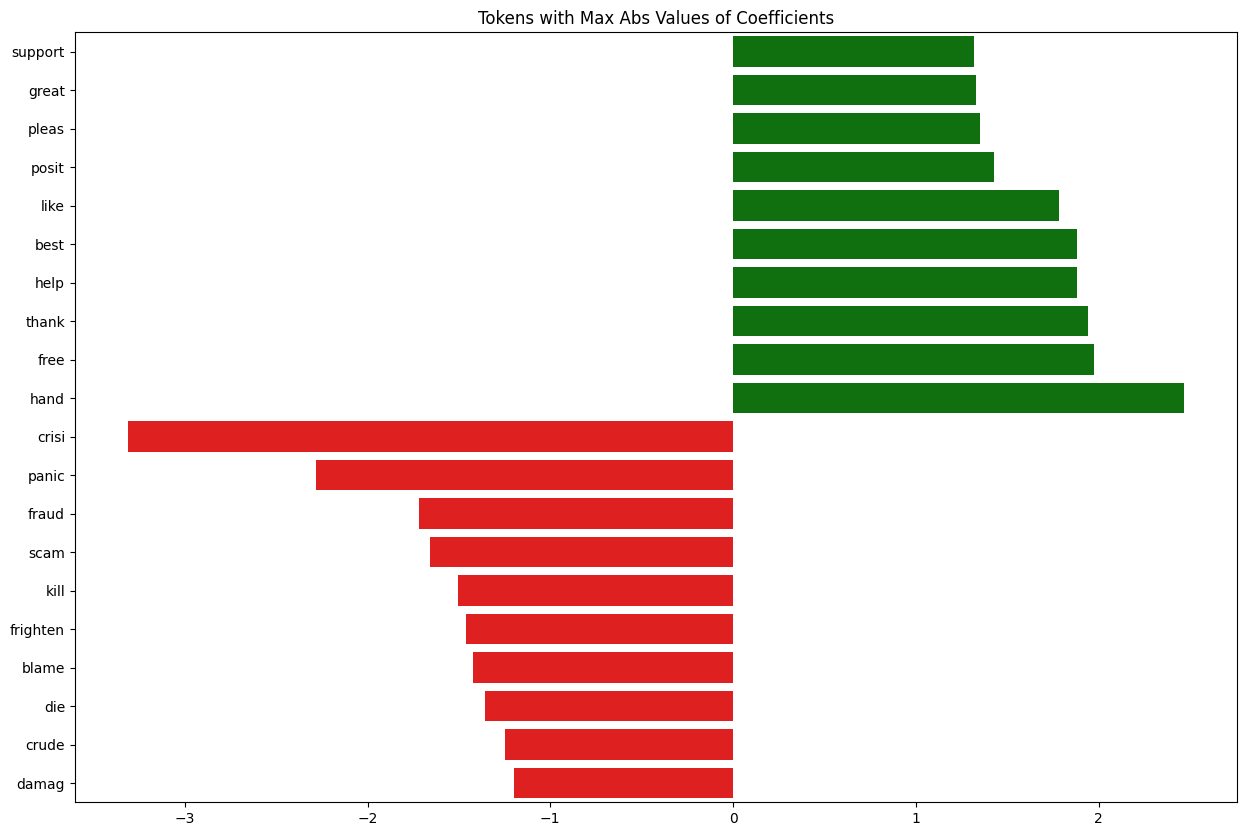

In [152]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=False)
x_scaled_train = scaler.fit_transform(x_train)
x_scaled_test = scaler.fit_transform(x_test)
model = LogisticRegression(max_iter=1000)
model.fit(x_scaled_train, y_train)
y_pred = model.predict(x_scaled_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

importance = model.coef_[0]
positive = np.argsort(importance)[-10:]
negative = np.argsort(importance)[:10]
print("Топ-10 положительных:", [cv_df.get_feature_names_out()[i] for i in positive])
print("Топ-10 отрицательных:", [cv_df.get_feature_names_out()[i] for i in negative])

fig, ax = plt.subplots(figsize=(15, 10))
top = np.hstack([positive, negative])
colors = ["green" if x > 0 else "red" for x in importance[top]]
sns.barplot(x=importance[top], y=[cv_df.get_feature_names_out()[i] for i in top], palette=colors)
plt.title("Tokens with Max Abs Values of Coefficients")
plt.show()

**Ответ:** Токены соответствуют тематике: положительные описывают помощь в пандемию, а отрицательные - ее ужасы (смерть, страх и другие)

## Задание 7 Другие признаки (1.5 балла)

Мы были сконцентрированы на работе с текстами твиттов и не использовали другие признаки - имена пользователя, дату и местоположение

Изучите признаки UserName и ScreenName. полезны ли они? Если полезны, то закодируйте их, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

**Ответ:** Мне они не кажутся бесполезными, поскольку окрас твита никак не зависит от имени пользователя, написавшего его.

Изучите признак TweetAt в обучающей выборке: преобразуйте его к типу datetime и нарисуйте его гистограмму с разделением по цвету на основе целевой переменной. Полезен ли он? Если полезен, то закодируйте его, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

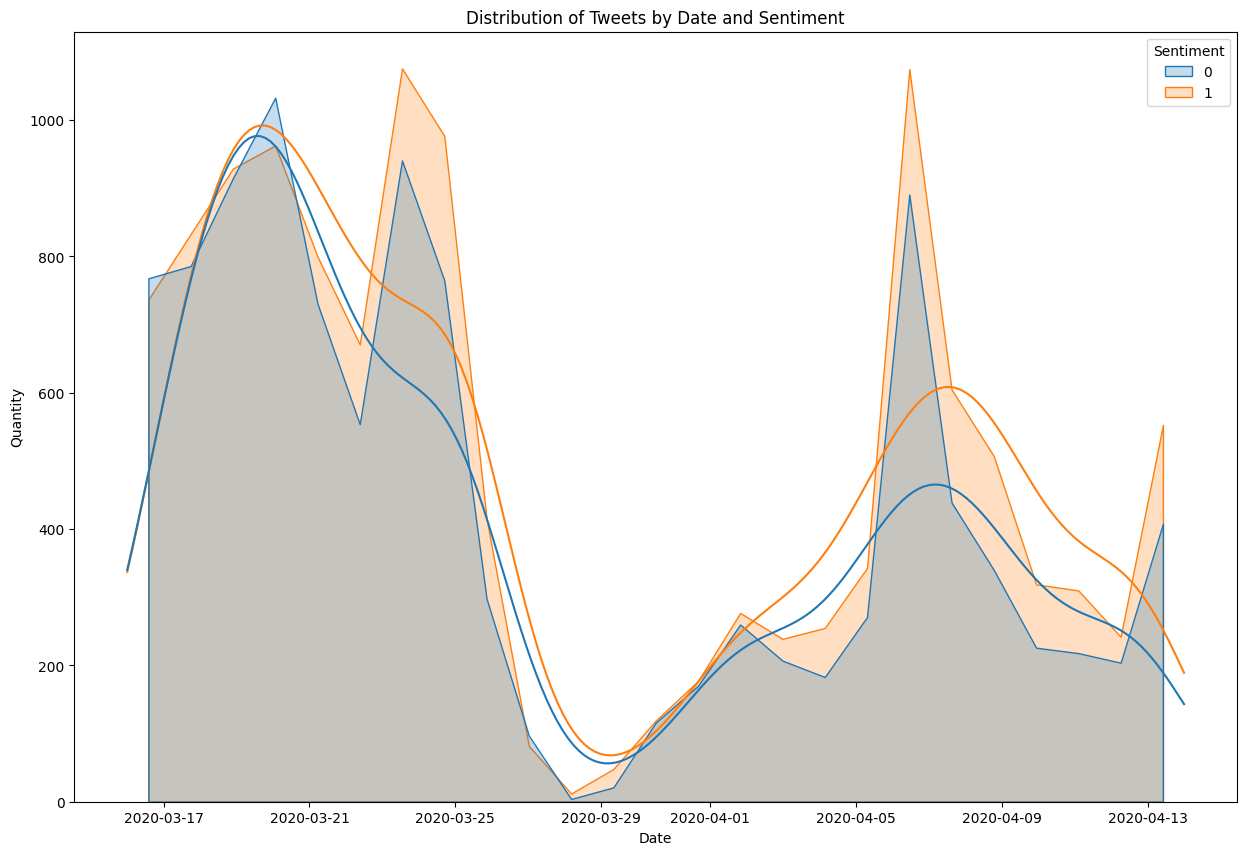

In [151]:
train['TweetAt'] = pd.to_datetime(train['TweetAt'], format='%d-%m-%Y')
plt.figure(figsize=(15, 10))
sns.histplot(data=train, x='TweetAt', hue='Sentiment', element='poly', kde=True)
plt.title("Distribution of Tweets by Date and Sentiment")
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.show()

**Ответ:** Признак TweetAt тоже не кажется мне полезным, нет даты, в которую количество положительных твитов сильно отличалось от количества отрицательных.



Поработайте с признаком Location в обучающей выборке. Сколько уникальных значений?

In [150]:
unique = train['Location'].nunique()
print(unique)

7949


Постройте гистограмму топ-10 по популярности местоположений (исключая Unknown)

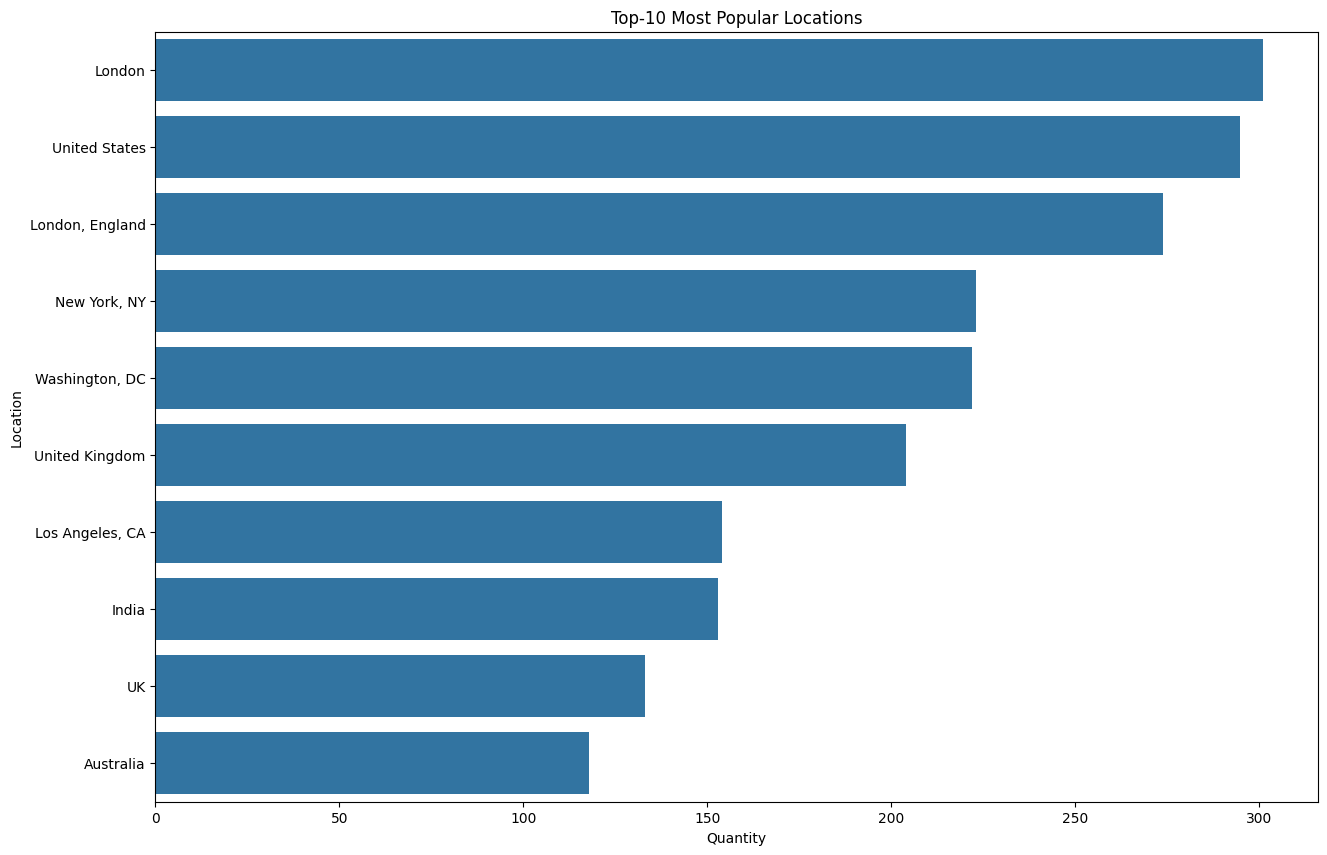

In [170]:
locations = train[train['Location'] != 'Unknown']['Location']
top = locations.value_counts().head(10)
plt.figure(figsize=(15, 10))
sns.barplot(x=top.values, y=top.index)
plt.title("Top-10 Most Popular Locations")
plt.xlabel("Quantity")
plt.ylabel("Location")
plt.show()

Видно, что многие местоположения включают в себя более точное название места, чем другие (Например, у некоторых стоит London, UK; а у некоторых просто UK или United Kingdom).

Создайте новый признак WiderLocation, который содержит самое широкое местоположение (например, из London, UK должно получиться UK). Сколько уникальных категорий теперь? Постройте аналогичную гистограмму.

In [173]:
train['WiderLocation'] = train['Location'].apply(lambda x: x.split(',')[-1].strip() if pd.notna(x) else x)
unique = train['WiderLocation'].nunique()
print(unique)

4631


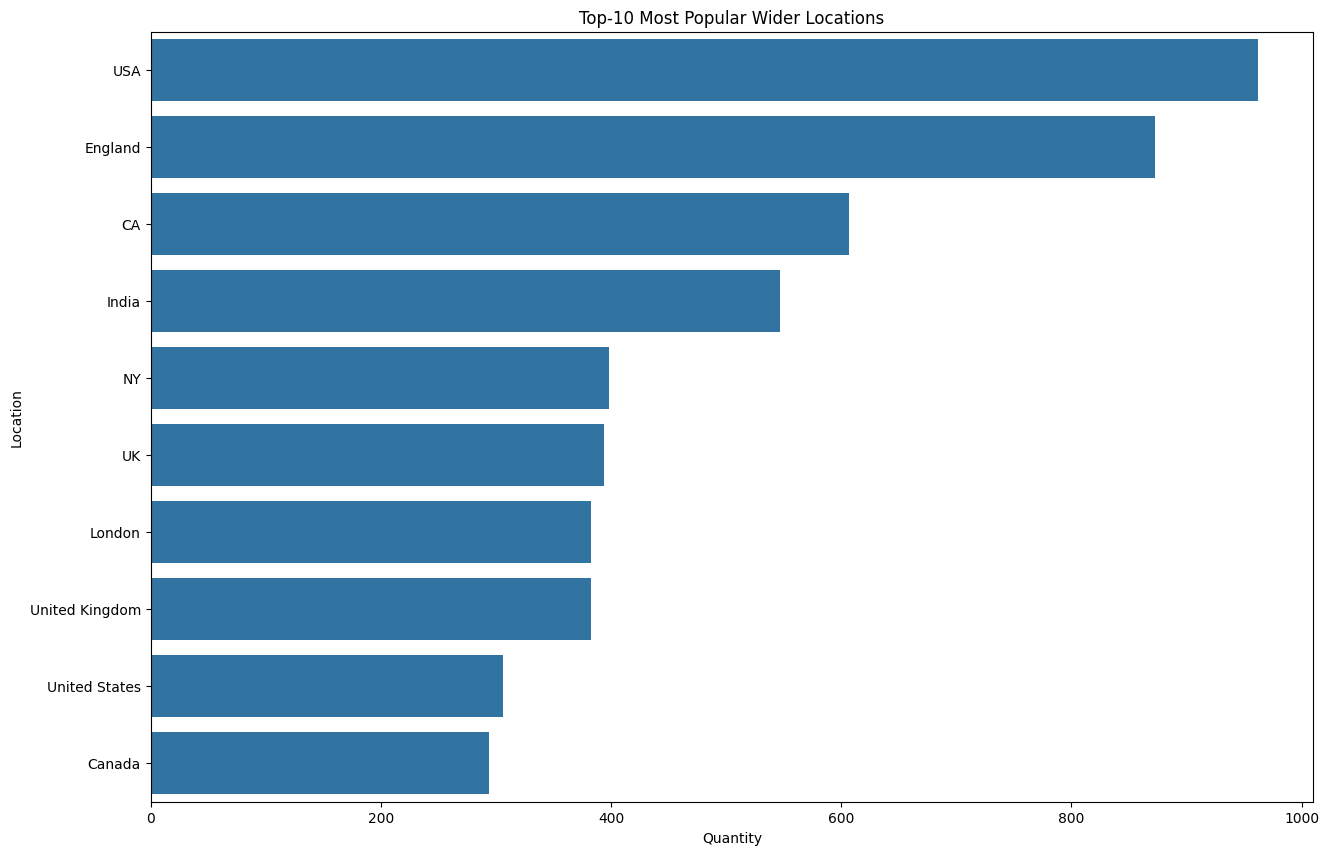

In [174]:
locations = train[train['WiderLocation'] != 'Unknown']['WiderLocation']
top = locations.value_counts().head(10)
plt.figure(figsize=(15, 10))
sns.barplot(x=top.values, y=top.index)
plt.title("Top-10 Most Popular Wider Locations")
plt.xlabel("Quantity")
plt.ylabel("Location")
plt.show()

Закодируйте признак WiderLocation с помощью OHE таким образом, чтобы создались только столбцы для местоположений, которые встречаются более одного раза. Сколько таких значений?


In [176]:
locations_count = train['WiderLocation'].value_counts()
locations_filtered = locations_count[locations_count > 1].index
print(len(locations_filtered))

988


Добавьте этот признак к матрице отскалированных текстовых признаков, обучите логистическую регрессию, замерьте качество. Как оно изменилось? Оказался ли признак полезным?


*Подсказка:* используйте параметр `categories` в энкодере.

In [181]:
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack

x_train, x_test, y_train, y_test = train_test_split(train['OriginalTweet'], train['Sentiment'], test_size=0.3, random_state=0)
x_location_train = train.loc[x_train.index, 'WiderLocation']
x_location_test = train.loc[x_test.index, 'WiderLocation']

encoder = OneHotEncoder(handle_unknown='ignore')
x_location_train_encoded = encoder.fit_transform(x_location_train.values.reshape(-1, 1))
x_location_test_encoded = encoder.transform(x_location_test.values.reshape(-1, 1))

x_train_combined = hstack([x_scaled_train, x_location_train_encoded])
x_test_combined = hstack([x_scaled_test, x_location_test_encoded])

model = LogisticRegression(max_iter=1000)
model.fit(x_train_combined, y_train)

x_pred = model.predict(x_test_combined)
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)

Accuracy: 0.8010821586216716


**Ответ:** Точность модели ухудшилась, значит, эмоциональная окраска твитов не зависит от местоположения пользователей.